In [20]:
#We are interested in divergent hnRNPM events to figure out the cell type specificity of hnRNPM. These divergent events can be gene expression, splicing, and binding.

#An additional filter for these events will be whether or not they occur during EMT

#On these three categories I will run GO term analyses per DAVID and GRACE

In [21]:
#need to automate go analysis with david
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mplv
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
import re
import scipy.stats as ss
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline
mpl.rc("lines", markeredgewidth=0.5)


In [22]:
#Most of this is already in the master go analysis ipython notebook

In [23]:
ls

cc1_cc4_all_spliced_genes
cc1_cc4_and_hh5_hh6_background_genes
cc1_cc4_and_hh5_hh6_background_genes_sorted
cc1_cc4_and_hh5_hh6_background_genes_uniq
cc1_cc4_background_genes_fpkm_1*
cc1_cc4_union_vs_hh5_hh6_gene_exp.txt*
cc1_cc4_vs_hh5_hh6_splicing.txt*
david_go_analysis/
divergent hnrnpm events and go analysis.ipynb
hh5_hh6_all_spliced_genes
hh5_hh6_background_genes_fpkm_1*
hnM_EPI_gene
hnM_EPI_gene.withBG.chartReport
hnM_EPI_splice
hnM_EPI_splice.withBG.chartReport
hnM_gene_intersection
hnM_gene_intersection.withBG.chartReport
hnM_MES_gene
hnM_MES_gene.withBG.chartReport
hnM_MES_splice
hnM_MES_splice.withBG.chartReport
hnM_splice_intersection
hnM_splice_intersection.withBG.chartReport
old_stuff/
twist_all_spliced_genes
twist_background_genes_fpkm_1


In [48]:
#write a function to go into the david output and collect the data for the 3 bar graphs and then plot
#How am I going to do this. Pull everything out as a dataframe
def david_bar_graph(david_sample_1_file,david_sample_2_file,david_intersection_file,sample_1,sample_2,go_term_id,sig_cutoff):
    '''This actually just takes 3 david files and then outputs the bar graph for each of them'''
    sample_1_only = pd.read_csv(david_sample_1_file,sep='\t')
    sample_2_only = pd.read_csv(david_sample_2_file,sep='\t')
    intersection = pd.read_csv(david_intersection_file,sep='\t')

    #collect only the GOTERM_BP_DIRECT
    def collect_id_of_interest(id_of_interest,dataframe):
        dataframe = dataframe[dataframe.Category == id_of_interest]
        return dataframe

    sample_1_only = collect_id_of_interest(go_term_id,sample_1_only)
    sample_2_only = collect_id_of_interest(go_term_id,sample_2_only)
    intersection = collect_id_of_interest(go_term_id,intersection)

    #now need to filter by a neg_log_p value
    def neg_log_p_and_filter_go(cutoff,dataframe):
        dataframe['neglogP'] = dataframe.apply(lambda row: -1*log(row['Pvalue'],10),axis=1)
        dataframe = dataframe[dataframe.neglogP > cutoff]
        #set a top 10
        dataframe = dataframe.head(5)
        return dataframe

    sample_1_only = neg_log_p_and_filter_go(sig_cutoff,sample_1_only)
    sample_2_only = neg_log_p_and_filter_go(sig_cutoff,sample_2_only)
    intersection = neg_log_p_and_filter_go(sig_cutoff,intersection)
    
    sample_1_only['sample'] = sample_1
    sample_2_only['sample'] = sample_2
    intersection['sample'] = sample_1+'\nand '+sample_2
    
    combined = pd.concat([sample_1_only,sample_2_only,intersection],ignore_index=True)
    
    #how could I plot side by side?
    #try an sns barplot after concat
    sns.set(font_scale=2.5)
    plt.figure(figsize=(10,15))
    sns.barplot(x='neglogP',y='Term',hue='sample',data=combined,orient='h')
    plt.legend(bbox_to_anchor=(1.75,1))

    #now blot a bar graph for each one
#     fig,ax = plt.subplots(3,1,figsize=(10,20),sharey=False,sharex=True)
#     sample_1_only.plot.barh(x='Term',y='neglogP',fontsize=15,ax=ax[0],label=sample_1+'_only',color='r')
#     sample_2_only.plot.barh(x='Term',y='neglogP',fontsize=15,ax=ax[1],label=sample_2+'_only',color='g')
#     intersection.plot.barh(x='Term',y='neglogP',fontsize=15,ax=ax[2],label=sample_1+'_and_'+sample_2,color='y')
        
    #add tables
#     from pandas.tools.plotting import table
#     table(ax[0],sample_1_only[['Count','%']],loc='right')
    
    #Figure out how to set a label with how many genes there are in each go term



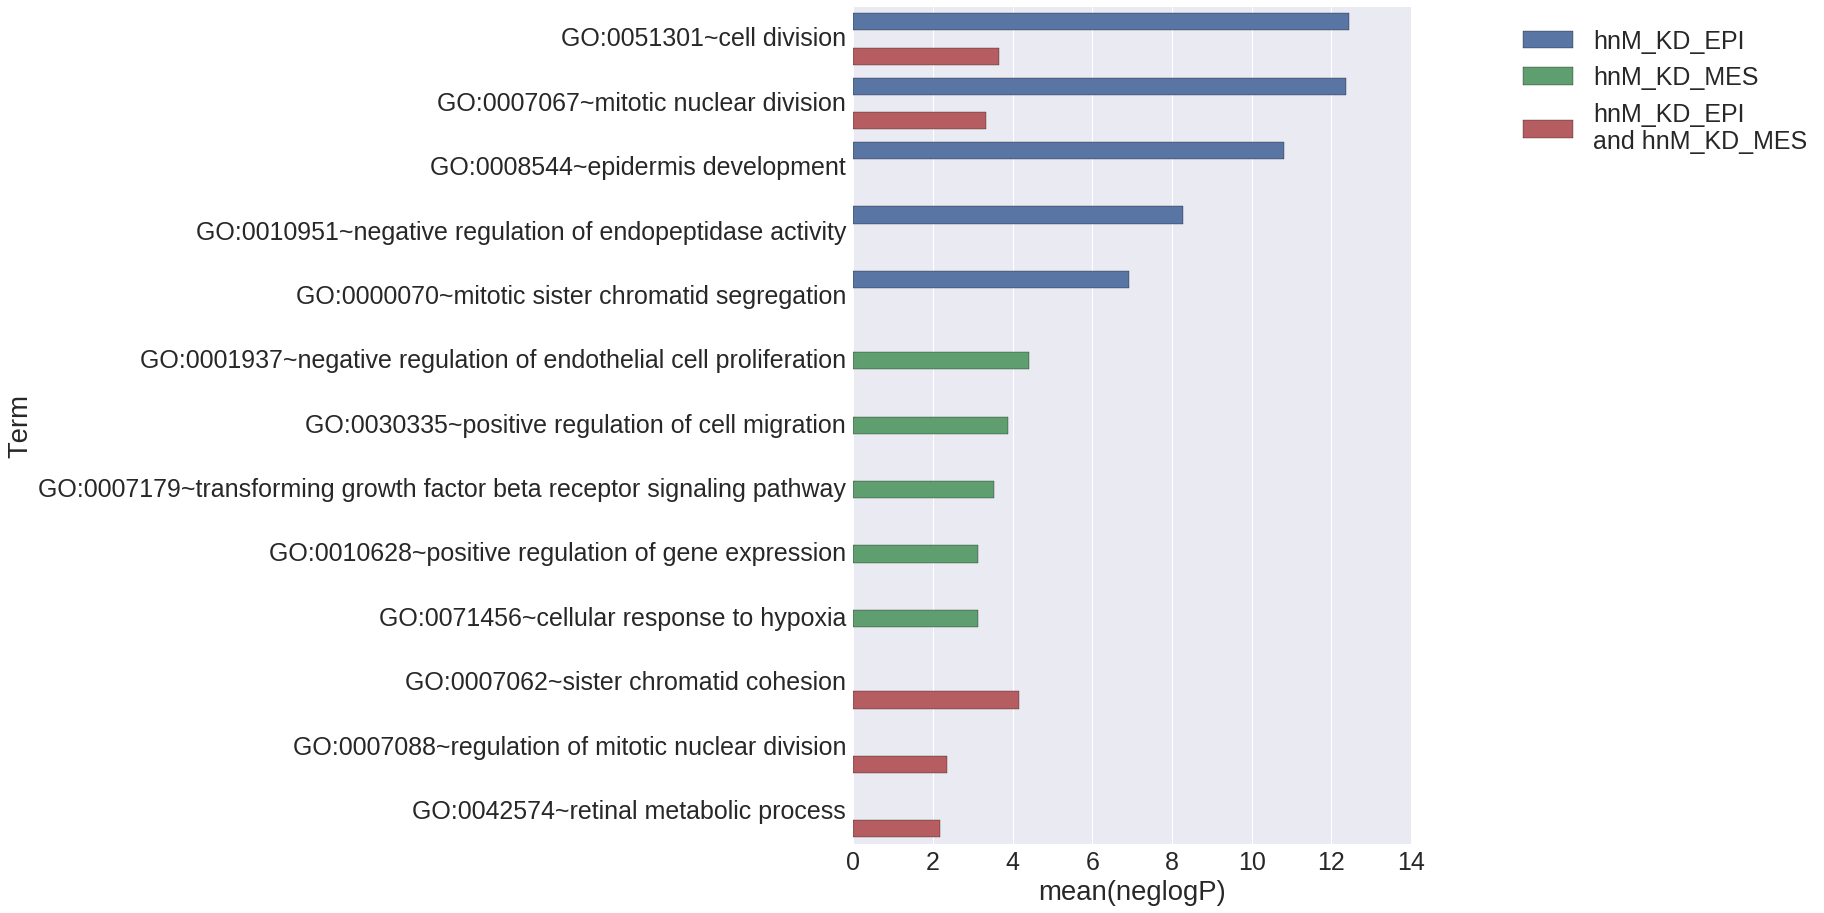

In [51]:
#compare hnRNPM genes - with background
hnM_epi_gene = 'hnM_EPI_gene.withBG.chartReport'
hnM_mes_gene = 'hnM_MES_gene.withBG.chartReport'
hnM_gene_intersection = 'hnM_gene_intersection.withBG.chartReport'
david_bar_graph(hnM_epi_gene,hnM_mes_gene,hnM_gene_intersection,'hnM_KD_EPI','hnM_KD_MES','GOTERM_BP_DIRECT',1)

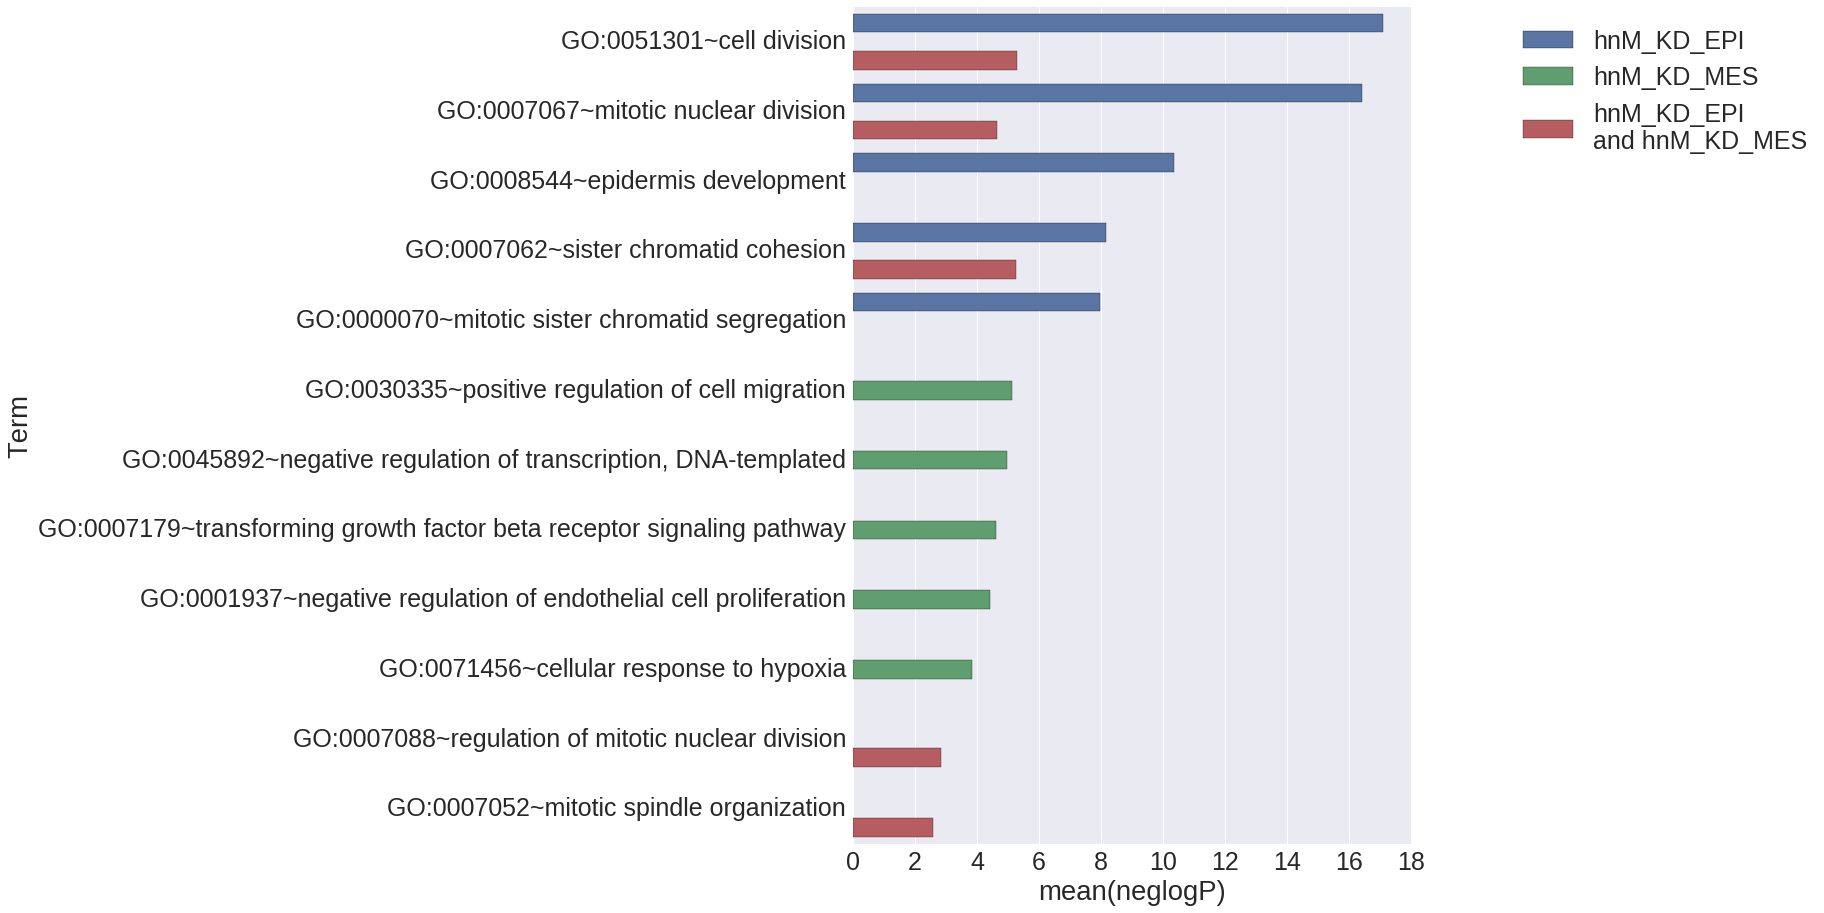

In [54]:
#compare hnRNPM genes - withOUT background
hnM_epi_gene = 'hnM_EPI_gene.chartReport'
hnM_mes_gene = 'hnM_MES_gene.chartReport'
hnM_gene_intersection = 'hnM_gene_intersection.chartReport'
david_bar_graph(hnM_epi_gene,hnM_mes_gene,hnM_gene_intersection,'hnM_KD_EPI','hnM_KD_MES','GOTERM_BP_DIRECT',1)

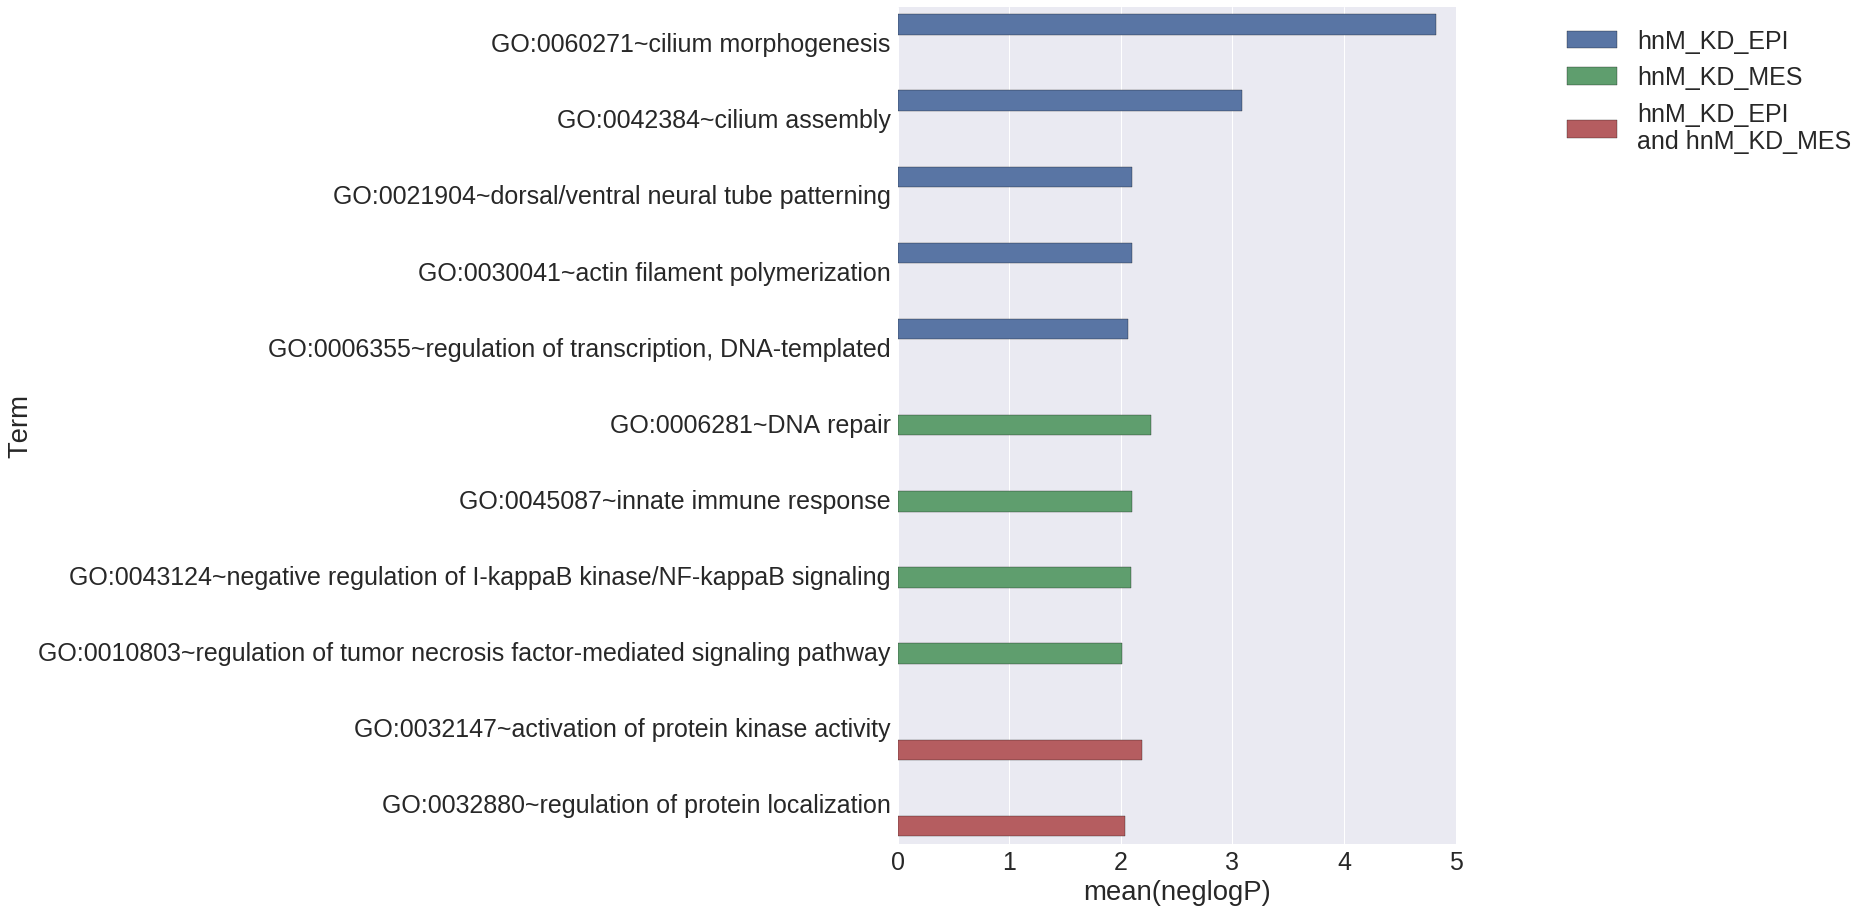

In [53]:
#compare hnRNPM splice - what is the proper background
hnM_epi_splice = 'hnM_EPI_splice.withBG.chartReport'
hnM_mes_splice = 'hnM_MES_splice.withBG.chartReport'
hnM_splice_intersection = 'hnM_splice_intersection.withBG.chartReport'
david_bar_graph(hnM_epi_splice,hnM_mes_splice,hnM_splice_intersection,'hnM_KD_EPI','hnM_KD_MES','GOTERM_BP_DIRECT',2)